In [2]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simps
import csv
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.fft import fft
from dataclasses import dataclass
from dataclasses import fields
import string
from tqdm import tqdm
import mpltern
from mpltern.datasets import get_triangular_grid

In [3]:
def gaussian(x, fwhm, cwl):
    """
    Outputs Gaussian function given input array 'x', based upon the Full-Width Half-Max (FWHM), and the Central WaveLength(CWL)

    """

    sigma = fwhm / (2*np.sqrt(2 * np.log(2)))
    mu = cwl
    G = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2/(2*sigma**2))

    # Normalise to 1
    G /= np.max(G)
    
    return G

def tophat(x, cutOn, width):
    return (x > cutOn) * (x < (cutOn + width))

def monoDecay(t, tau, Anorm = False):
    """
    Outputs a mono-exponential decay given an array of time values, a lifetime / decay time*, 
    and a photon number to apply shot noise with
    
    *the lifetime is defined such that after 1 lifetime the value of the function has been reduced by a factor of 1 / e
    (where e is the fundemental constant 2.78.....)
    
    """
    
    I = np.exp(-t / tau)
    if Anorm:
        Iout = I /simps(I)
    else:
        Iout = I
    return Iout


def biDecay(t, a1, tau1, a2, tau2, Anorm = False):
    """
    Outputs a biexponential decay given an array of time values, a lifetimes / decay times* and realtive concentrations, 
    and a photon number to apply shot noise with
    
    *the lifetime is defined such that after 1 lifetime the value of the function has been reduced by a factor of 1 / e
    (where e is the fundemental constant 2.78.....)
    
    """
    I = a1*np.exp(-t / tau1) + a2*np.exp(-t / tau2)
    if Anorm:
        Iout = I /simps(I)
    else:
        Iout = I
        
    return Iout

def ampWeigthing(a1, tau1, a2, tau2):
    lifetimeOut = (a1*tau1 + a2*tau2)*(a1+a2)
    return lifetimeOut

def generateKey(length):
    datasetkey = ''
    ALPHABET = np.array(list(string.ascii_lowercase))
    keyarr =  np.random.choice(ALPHABET, size=length)
    for letters in keyarr:
        datasetkey += letters
    print(datasetkey)
    return datasetkey

def resampleSpectra(raw_spectra, wav_new):
    """
    This functions takes in a spectra and resamples over a given wavelength range, and number of wavelength steps.
    Inputs:
    -------
    wavOld : x-axis or wavlength of spectra to resample
    spectra: intensity of spectra
    
    
    
    """
    spectra = raw_spectra[:,1]
    wav_old = raw_spectra[:,0]
    
    fSpectra = interp1d(wav_old, spectra)
    
    spectraNew = fSpectra(wav_new)
    
    spectraOut = spectraNew
    return spectraOut

In [18]:
@dataclass
class SFLIMdata:   
    """
    Class which creates an SFLIM data set comprising of 3 endmemebers with gaussian spectra and unique lifetimes.
    The endmembers can be simulated with variable numbers of bands, time bins, photon counts.
    The SFLIM data is simulated for a range of fluorophore abundances using an abundance map. (generated elsewhere).
    ----------------------------------------------------------------------------------------------------------------
    Methods:
    
    importSpectras : import the spectras for FAD, AGE, and A2E from csv files and re-interpolate them using the wavelength range and wavelength step supplied.
    generateFilters: generates a list of contiguous top hat functions over the wavelength range specified and with number bands also specified.
    generateDecays: generates either single or biexponential decays using an inputed list of decay parameters. For bi exponential decays this
    list should be structured as a nest list of shape [[a1, tau1,a2,tau 2],[a1, tau1,a2,tau 2],[a1, tau1,a2,tau 2]]
    generateSFLIMimage: generated the SFLIMimage by simulating the additive mixture of endmembers. 
    In this each pixel I(t,lambda) is normalised such that sum_[t, lambda]{I(t,lambda)} = 1 
    generatePlot: plots the endmember spectra, endmember decays, simulated spectral data, and the SFLIM data for a given pixel
    
    """
    
    NumberOfBands: int
    NumberOfBins: int
    Lifetimes: list[float]
    Abundances: list[float] 
    NumberOfPhotons: int = 0
    ImageRows : int = 100
    ImageCols : int = 100
    NumberOfWavelengths: int = 640
    StartWavelength: float = 500
    StopWavelength: float = 750
    TimePerBinPS: float = 47e-12


    
    def __post_init__(self):
        
        # sets up wavelength array, time array, and filter parameters
        self.WavelengthArr = np.linspace(start = self.StartWavelength, stop = self.StopWavelength, num = self.NumberOfWavelengths)
        self.TimeArr = np.arange(self.NumberOfBins)*self.TimePerBinPS
        self.FilterWidthNM = (self.StopWavelength - self.StartWavelength) / self.NumberOfBands
        self.FilterWidthIdx = int(self.NumberOfWavelengths /self.NumberOfBands)
    
    def importSpectras(self):
        # imports spectras, resamples, and normalises.
        AGEimport = np.loadtxt("/Users/danielgeddes/Library/CloudStorage/OneDrive-UniversityofGlasgow/FLIM-FundusCamera/AGE_455_796_Spectra.csv", delimiter = '\t')
        A2Eimport = np.loadtxt("/Users/danielgeddes/Library/CloudStorage/OneDrive-UniversityofGlasgow/FLIM-FundusCamera/A2E_455_796_Spectra.csv", delimiter = '\t')
        FADimport = np.loadtxt("/Users/danielgeddes/Library/CloudStorage/OneDrive-UniversityofGlasgow/FLIM-FundusCamera/FAD_455_796_Spectra.csv", delimiter = '\t')

        AGEspectra = resampleSpectra(AGEimport,self.WavelengthArr)
        A2Espectra = resampleSpectra(A2Eimport,self.WavelengthArr)
        FADspectra = resampleSpectra(FADimport, self.WavelengthArr)
        
        
        
        spectraList = np.array([AGEspectra,A2Espectra, FADspectra])
        self.spectraList = spectraList
        return spectraList
  
    def generateFilters(self):
        # generates filters for 

        filterList = np.array([tophat(self.WavelengthArr, cutons, self.FilterWidthNM) for cutons in self.WavelengthArr[::self.FilterWidthIdx]])
        
        self.Filter = filterList
        return filterList
    
    def generateDecays(self):
        
        lifetimes = self.Lifetimes
        
        # Bi exponential Decays
        if np.asarray(lifetimes).ndim > 1:
            decay1 = biDecay(self.TimeArr, *lifetimes[0])
            decay2 = biDecay(self.TimeArr, *lifetimes[1])
            decay3 = biDecay(self.TimeArr, *lifetimes[2])
        # Mono exponential decays    
        else:
            decay1 = monoDecay(self.TimeArr, lifetimes[0])
            decay2 = monoDecay(self.TimeArr, lifetimes[1])
            decay3 = monoDecay(self.TimeArr, lifetimes[2])

            
        decayList = np.array([decay1,decay2,decay3])
        
        self.Decays = decayList
        return decayList

    
    def generateSFLIMimage(self):
        spectraList = self.importSpectras()
        filterList = self.generateFilters()
        decayList = self.generateDecays()
        abundancevolume = self.Abundances
        
        
        sflimvolume = np.zeros(shape = (self.ImageRows, self.ImageCols, self.NumberOfBands, self.NumberOfBins))
        countsvolume = np.zeros(shape = (self.ImageRows, self.ImageCols, self.NumberOfBands))
        
        # generate SFLIM image without noise
        if self.NumberOfPhotons == 0:
            for i in tqdm(range(self.ImageRows)):
                for j in range(self.ImageCols):
                    tempAbundances = abundancevolume[i,j,:]
                    tempMixture = np.dot(tempAbundances, spectraList)
                    for idx,filters in enumerate(filterList):
                        
                        tempdecay = decayList[0,:] * tempAbundances[0] * np.dot(filters,spectraList[0,:])\
                        + decayList[1,:] * tempAbundances[1] * np.dot(filters,spectraList[1,:])\
                        + decayList[2,:] * tempAbundances[2] * np.dot(filters,spectraList[2,:])
                        if tempdecay.any():
                            tempdecay = tempdecay / simps(tempdecay)
                            tempdecay = tempdecay * np.sum((tempMixture / np.sum(tempMixture))*filters)
                        
                        sflimvolume[i,j,idx,:] = tempdecay    
                    sflimvolume[i,j,...] = sflimvolume[i,j,...] / np.max(sflimvolume[i,j,...])
        # generate SFLIMimage with poissionian noise applied.
        else:
            for i in tqdm(range(self.ImageRows)):
                for j in range(self.ImageCols):
                    tempAbundances = abundancevolume[i,j,:]
                    tempMixture = np.dot(tempAbundances, spectraList)
                    for idx, filters in enumerate(filterList):
                            
                        tempdecay = decayList[0,:] * tempAbundances[0]*np.dot(filters, spectraList[0,:]) \
                        + decayList[1,:] * tempAbundances[1]*np.dot(filters, spectraList[1,:]) \
                        + decayList[2,:] * tempAbundances[2]*np.dot(filters, spectraList[2,:])
                        #tempdecay = decayList[0,:] * tempAbundances[0] + decayList[1,:] * tempAbundances[1] + decayList[2,:] * tempAbundances[2]
                        if tempdecay.any():
                            tempdecay = tempdecay / simps(tempdecay)
                            temptcspc = tempdecay 
                            PhotonCount = self.NumberOfPhotons * np.sum((tempMixture / np.sum(tempMixture))*filters)
                            tempsflim = np.random.poisson(np.round((temptcspc*PhotonCount)))
                            countsvolume[i,j,idx] = PhotonCount
                            sflimvolume[i,j,idx,:] = tempsflim
        
        self.PhotonCounts = countsvolume
        self.SFLIMimage = sflimvolume
        return sflimvolume
    
    
    def generatePlot(self, xcoord, ycoord):
        # plot given pixel of SFLIMimage, endmember spectra, endmember decay, and spectral data
        SFLIMdecays = self.SFLIMimage[xcoord,ycoord,:,:].reshape(self.NumberOfBands, self.NumberOfBins)
        Counts = self.PhotonCounts[xcoord,ycoord, :]
        
        fig = plt.figure(figsize = (15,20))

        fig_grid = fig.add_gridspec(4,3)
        ax1 = fig.add_subplot(fig_grid[0,0])
        ax2 = fig.add_subplot(fig_grid[0,1])
        ax3 = fig.add_subplot(fig_grid[0,2])
        ax4 = fig.add_subplot(fig_grid[1:,:], projection = '3d')

        ax1.plot(self.WavelengthArr, self.spectraList[0,:], label = 'AGE')
        ax1.plot(self.WavelengthArr, self.spectraList[1,:], label = 'A2E')
        ax1.plot(self.WavelengthArr, self.spectraList[2,:], label = 'FAD')
        ax1.set_xlabel('Wavelength - nm')
        ax1.set_ylabel('Intensity a.u.')
        ax1.set_title('Endmember Spectra')
        ax1.legend()


        ax2.plot(self.StartWavelength + self.FilterWidthNM*np.arange(self.NumberOfBands), Counts)
        ax2.set_xlabel('Wavelength - nm')
        ax2.set_ylabel('Photon Counts')  
        ax2.set_title('Photon Counts Per Waveband')

        colors = cm.turbo(np.linspace(0,1,self.NumberOfBands))
        for idx, decays in enumerate(SFLIMdecays):
            ax3.plot(self.TimeArr*1e9, decays, c = colors[idx])
            ax4.plot(self.TimeArr*1e9, (self.StartWavelength + self.FilterWidthNM*idx)*np.ones(self.NumberOfBins), decays, c = colors[idx])


        ax3.set_xlabel('Times - ns')
        ax3.set_ylabel('Photon Counts')
        ax3.set_title('Spectrally Resolved Fluorescence Decays')
        ax4.set_xlabel('Time - ns', fontsize = 15)
        ax4.set_ylabel('Wavelength - nm', fontsize = 15)
        ax4.set_zlabel('Photon Counts',fontsize = 15)
        ax4.set_title('Spectrally Resolved Fluorescence Decays')
        ax4.zaxis._axinfo['juggled'] = (1,2,0)

        ax4.set_yticks([500,550,600,650,700,750])

        ax4.axes.set_xlim3d( left=(1e9*self.TimeArr.min()+0.3),  right=(1e9*self.TimeArr.max()-0.2))
        ax4.axes.set_ylim3d(bottom=500.3, top=749.8) 

# Generate Abundance Maps

In [23]:

a1 = np.linspace(start = 0, stop = 10, num = 11)**2
a2 = np.linspace(start = 0, stop = 10, num = 11)**2
print(a1)
v1,v2 = np.meshgrid(a1,a2)

[  0.   1.   4.   9.  16.  25.  36.  49.  64.  81. 100.]


In [24]:
#vec = np.array([[0],[1],[2],[3],[4],[4],[3],[2],[1],[0]])
#print(vec.shape)
map1 = (v1+v2) / np.max(v1+v2)

zeroidxs1 = ([0,10],[10,0])

map1[zeroidxs1] = 0

map2 = np.copy(map1[::-1,:])
map3 = np.copy(map1[:,::-1])
map1[0,0]=0.34
map2[0,0] = 0.33
map3[0,0] = 0.33



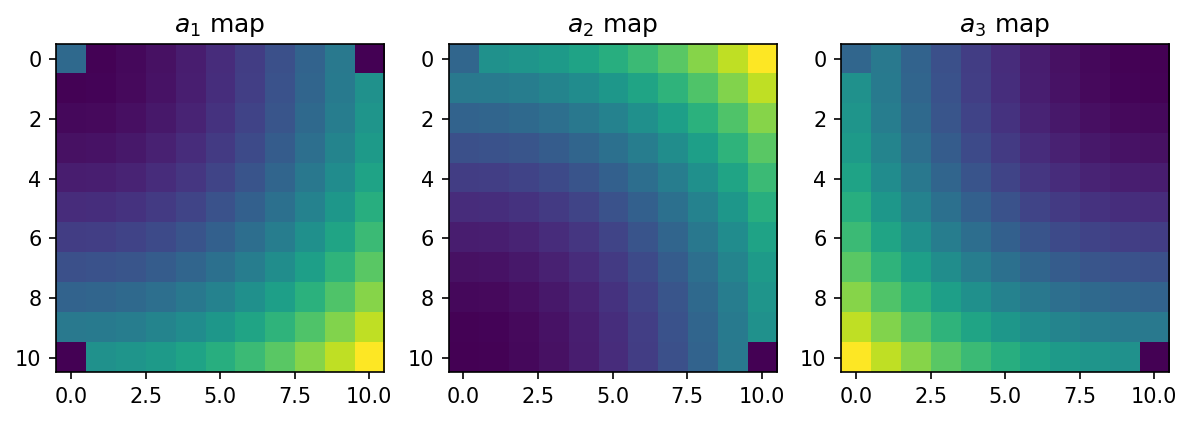

In [25]:
fig = plt.figure(figsize = (8,4), dpi = 150)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)


ax1.imshow(map1)
ax1.set_title(r'$a_{1}$ map')


ax2.imshow(map2)
ax2.set_title(r'$a_{2}$ map')

ax3.imshow(map3)
ax3.set_title(r'$a_{3}$ map')
plt.tight_layout()
plt.show()

In [26]:
# round these maps so that they sum to 1
a1map = np.zeros(shape = map1.shape)
a2map = np.zeros(shape = map1.shape)
a3map = np.zeros(shape = map1.shape)


for x in range(11):
    for y in range(11):
        tempabund = np.array([map1[x,y], map2[x,y],map3[x,y]])
        tempnorm = tempabund / np.sum(tempabund)
        a1map[x,y] = tempnorm[0]
        a2map[x,y] = tempnorm[1]
        a3map[x,y] = tempnorm[2]
    
# kernel = np.ones((10,10))
# a1map = np.kron(a1map, kernel)
# a2map = np.kron(a2map, kernel)
# a3map = np.kron(a3map, kernel)

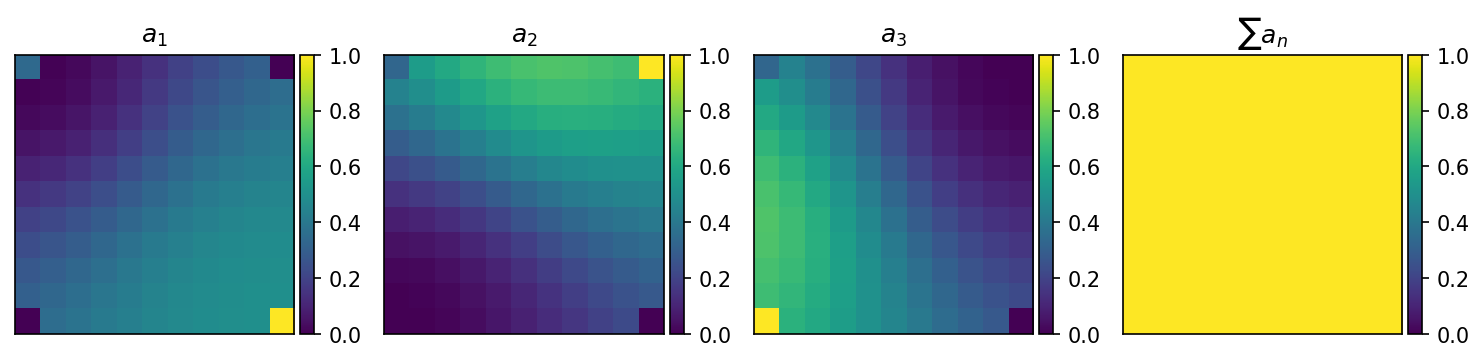

In [27]:
fig = plt.figure(figsize = (10,8), dpi = 150)
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

im1 = ax1.imshow(a1map)
ax1.set_title(r'$a_{1}$')
im2 = ax2.imshow(a2map)
ax2.set_title(r'$a_{2}$')
im3 = ax3.imshow(a3map)
ax3.set_title(r'$a_{3}$')
im4 = ax4.imshow(a1map + a2map + a3map)
ax4.set_title(r'$\sum a_{n}$')
axeslist = [ax1,ax2,ax3,ax4]
imlist = [im1,im2,im3,im4]



for i in range(len(axeslist)):
    ax = axeslist[i]
    im = imlist[i]
    im.set_clim((0,1))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size = '5%', pad = 0.04)
    cbar = fig.colorbar(im, cax = cax , orientation = 'vertical')
    cbar.ax.tick_params(labelsize = 10)
    ax.tick_params(left = False, labelbottom = False)
    ax.tick_params(bottom = False, labelleft=False)


plt.tight_layout()
#plt.savefig('abundancemaps.png')
plt.show()

In [28]:
abundancemap = np.array([a1map, a2map,a3map]).T
print(abundancemap.shape)


(11, 11, 3)


# Generate SFLIM data


In [29]:
def IntensityWeightedLifetime(TauVector):
    return np.dot(TauVector[::2],TauVector[1::2]**2)/ np.dot(TauVector[::2],TauVector[1::2])

In [30]:
# approximate retinal fluorophore lifetimes using 
fadLifetimes = [0.18, 0.33e-9, 0.82, 2.810e-9]
ageLifetimes = [0.62, 0.865e-9, 0.38, 4.170e-9]
a2eLifetimes = [0.48, 0.39e-9, 0.52, 2.240e-9]

def AmplitudeWeightedLifetime(TauVector):
    return np.dot(TauVector[::2], TauVector[1::2])


fadtau = AmplitudeWeightedLifetime(fadLifetimes)
agetau = AmplitudeWeightedLifetime(ageLifetimes)
a2etau = AmplitudeWeightedLifetime(a2eLifetimes)
print(a2etau)

1.352e-09


In [31]:
fadint = IntensityWeightedLifetime(np.array(fadLifetimes))
ageint = IntensityWeightedLifetime(np.array(ageLifetimes))
a2eint = IntensityWeightedLifetime(np.array(a2eLifetimes))
print(a2eint)

1.9838461538461536e-09


In [32]:
attrDict = {'bands':32,
           'bins' : 256,
           'lifetimes' : [ageLifetimes, a2eLifetimes, fadLifetimes],
            #'lifetimes' : [agetau*(1.05), a2etau*(1.05), fadtau],
           'abundances': abundancemap,
           'photoncount': 0,
            'imagerows': 11,
            'imagecols': 11,
           }

In [33]:
sflimdataobject = SFLIMdata(attrDict['bands'], attrDict['bins'], attrDict['lifetimes'], attrDict['abundances'], attrDict['photoncount'], attrDict['imagerows'], attrDict['imagecols'])


sflimdataset = sflimdataobject.generateSFLIMimage()

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 96.52it/s]


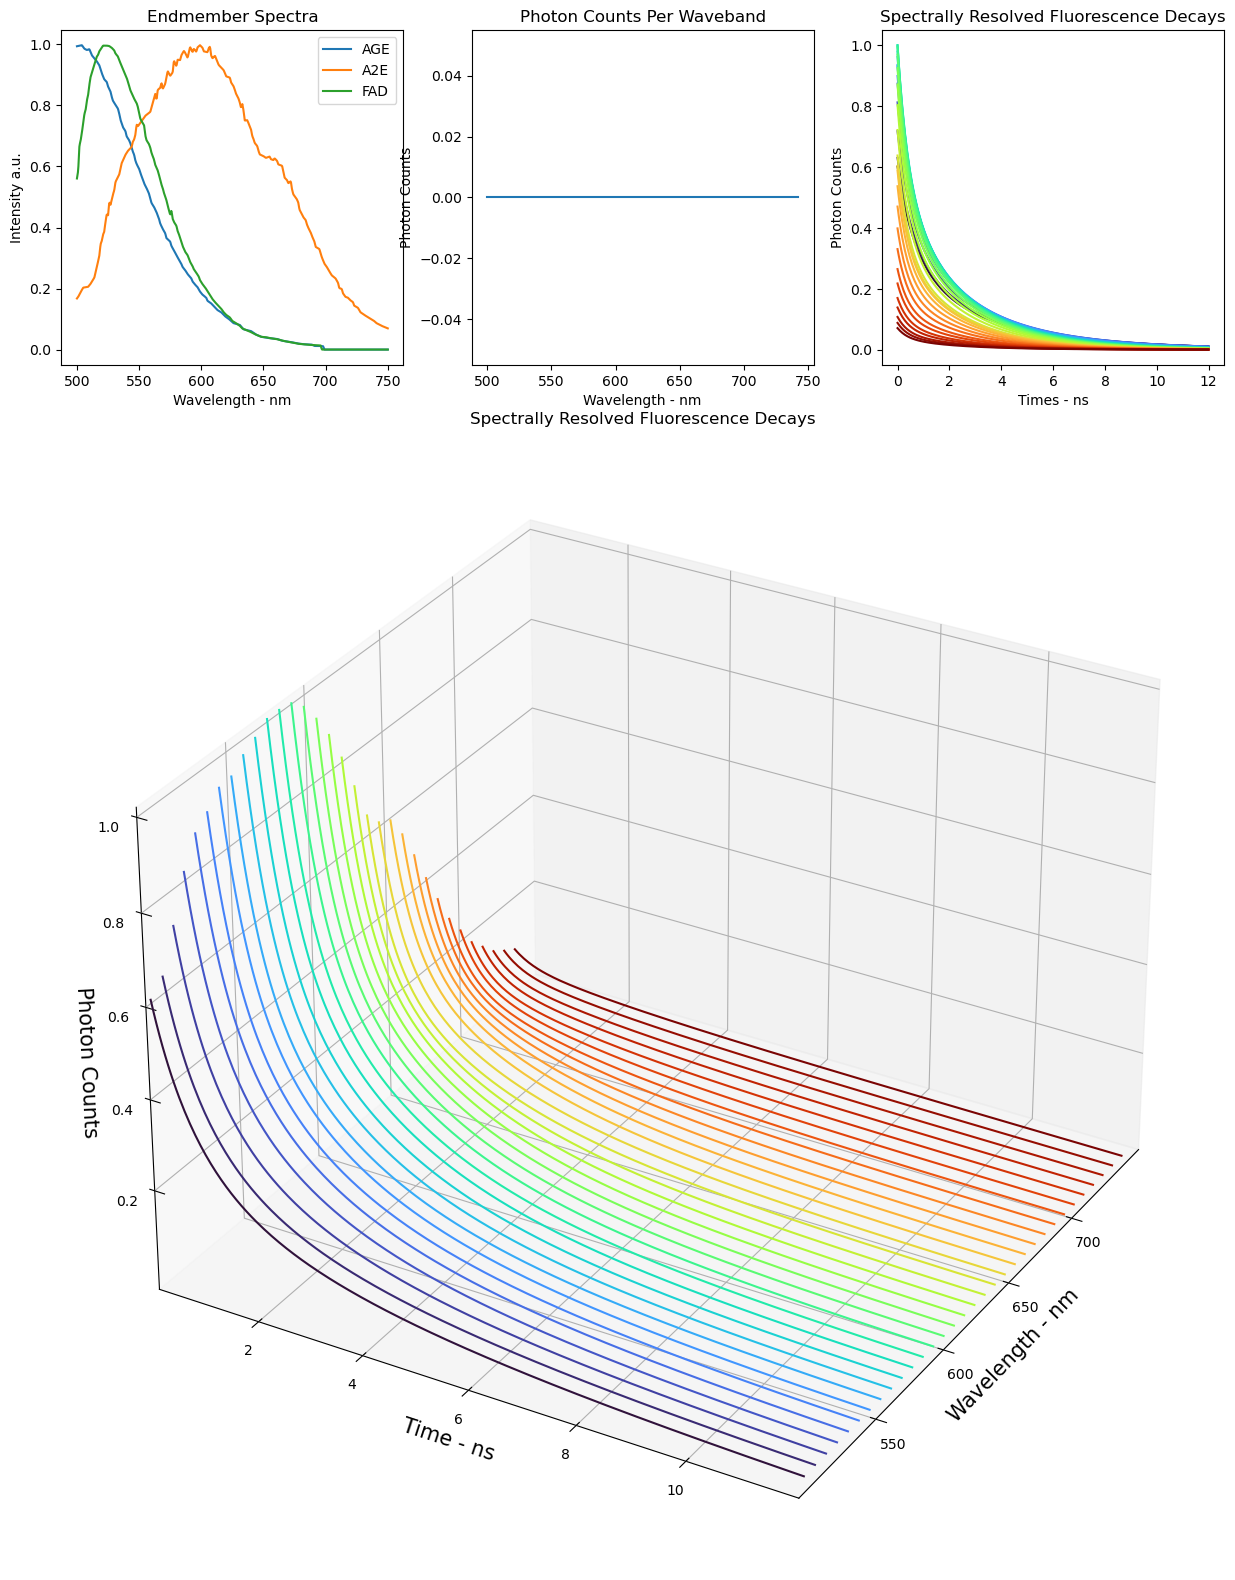

In [34]:
sflimdataobject.generatePlot(xcoord = 8, ycoord = 3)

# Save Data

In [35]:
keylength = 10
datasetkey = generateKey(keylength)
metaDict = {'Lifetimes-ns' : sflimdataobject.Lifetimes,
            'PhotonCount' : sflimdataobject.NumberOfPhotons,
            'WavelengthRange' : [sflimdataobject.StartWavelength, sflimdataobject.StopWavelength],
            'NumberOfWavlengths' : sflimdataobject.NumberOfWavelengths,
            'Spectra1' : 'AGE',
            'Spectra2' : 'A2E',
            'Spectra3' : 'FAD',
            'NumBins': sflimdataobject.NumberOfBins,
            'NumBands' : sflimdataobject.NumberOfBands,
            'NumRows': sflimdataobject.ImageRows,
            'NumCols':sflimdataobject.ImageCols,
            'Filterwidth' : sflimdataobject.FilterWidthNM,
            'TimePerBinPS' : sflimdataobject.TimePerBinPS,
            'DatasetKey' : datasetkey,
            'Notes': 'S-FLIM data consists of a mixture of retinal fluorophores'
           }
print(metaDict)

rvlsdiiyqz
{'Lifetimes-ns': [[0.62, 8.65e-10, 0.38, 4.17e-09], [0.48, 3.9e-10, 0.52, 2.24e-09], [0.18, 3.3e-10, 0.82, 2.81e-09]], 'PhotonCount': 0, 'WavelengthRange': [500, 750], 'NumberOfWavlengths': 640, 'Spectra1': 'AGE', 'Spectra2': 'A2E', 'Spectra3': 'FAD', 'NumBins': 256, 'NumBands': 32, 'NumRows': 11, 'NumCols': 11, 'Filterwidth': 7.8125, 'TimePerBinPS': 4.7e-11, 'DatasetKey': 'rvlsdiiyqz', 'Notes': 'S-FLIM data consists of a mixture of retinal fluorophores'}


In [36]:
#Save Data
dirname = r'SFLIM-AbundanceRecovery/SFLIM-Data06-05-23'

#Save Endmembers
np.savetxt(os.path.join(dirname, 'EndmemberSpectra_' + datasetkey + '.txt'), sflimdataobject.spectraList,delimiter = '\t')
#Save FilterSpectras
np.savetxt(os.path.join(dirname, 'FilterSpectras_' + datasetkey + '.txt'), sflimdataobject.Filter, delimiter = '\t')

#Save S-FLIM image
with open(os.path.join(dirname, 'SFLIMimage_' + datasetkey + '.npy'), 'wb') as f:
        np.save(f, sflimdataset)

#save Decays
np.savetxt(os.path.join(dirname, 'Decays_' + datasetkey + '.txt') , sflimdataobject.Decays, delimiter = '\t')

# Save metadata
json.dump(metaDict, open(os.path.join(dirname, 'MetaData_'+datasetkey+'.json'), 'w'))

# Save Photon Counts
if sflimdataobject.NumberOfPhotons >= 0:
    with open(os.path.join(dirname, 'PhotonCounts_'+ datasetkey + '.npy') , 'wb') as f:
              np.save(f,sflimdataobject.PhotonCounts)
    
# Save Abundances
with open(os.path.join(dirname, 'Abundances_'+ datasetkey + '.npy'), 'wb') as f:
              np.save(f,sflimdataobject.Abundances)      